In [4]:
import pandas as pd

# Load the datasets from the uploaded files
red_wine = pd.read_csv('data/winequality-red.csv', delimiter=';')
white_wine = pd.read_csv('data/winequality-white.csv', delimiter=';')

# Combine both datasets into a single DataFrame
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

# Display the first few rows of the dataset and some summary statistics
wine_data.head(), wine_data.describe(), wine_data['quality'].value_counts()


(   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.4              0.70         0.00             1.9      0.076   
 1            7.8              0.88         0.00             2.6      0.098   
 2            7.8              0.76         0.04             2.3      0.092   
 3           11.2              0.28         0.56             1.9      0.075   
 4            7.4              0.70         0.00             1.9      0.076   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 11.0                  34.0   0.9978  3.51       0.56   
 1                 25.0                  67.0   0.9968  3.20       0.68   
 2                 15.0                  54.0   0.9970  3.26       0.65   
 3                 17.0                  60.0   0.9980  3.16       0.58   
 4                 11.0                  34.0   0.9978  3.51       0.56   
 
    alcohol  quality  
 0      9.4        5  
 1      9.8        5  
 2 

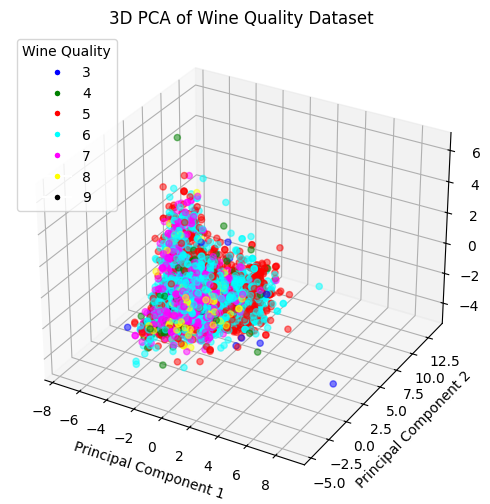

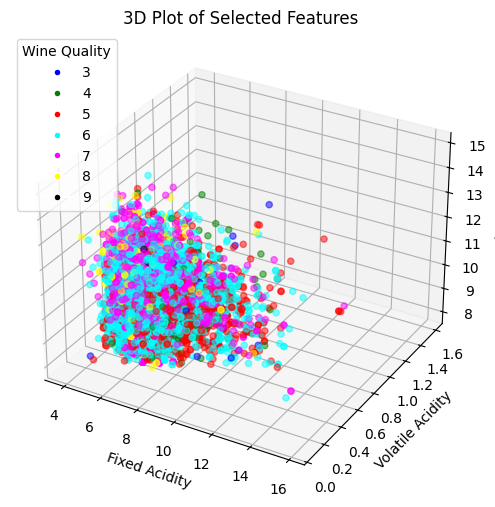

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Load datasets
red_wine_path = "data/winequality-red.csv"
white_wine_path = "data/winequality-white.csv"
red_wine_data = pd.read_csv(red_wine_path, delimiter=';')
white_wine_data = pd.read_csv(white_wine_path, delimiter=';')

# Combine
wine_data = pd.concat([red_wine_data, white_wine_data])

# Separate features and target
features = wine_data.drop('quality', axis=1)
labels = wine_data['quality']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Define a fixed list of colors
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'lime', 'orange', 'brown']
color_map = {quality: colors[i] for i, quality in enumerate(sorted(labels.unique()))}

# PCA for visualization (reducing to 3 components for a 3D plot)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# 3D PCA Visualization in a separate figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=[color_map[q] for q in labels], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Wine Quality Dataset')

# Creating a legend with the quality scores
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[quality], markersize=5, label=quality) for quality in sorted(color_map)]
ax.legend(handles=handles, title="Wine Quality", loc='upper left')
plt.show()


# 3D Plot of selected features in a separate figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(wine_data['fixed acidity'], wine_data['volatile acidity'], wine_data['alcohol'], c=[color_map[q] for q in labels], alpha=0.5)
ax.set_xlabel('Fixed Acidity')
ax.set_ylabel('Volatile Acidity')
ax.set_zlabel('Alcohol')
ax.set_title('3D Plot of Selected Features')
ax.legend(handles=handles, title="Wine Quality", loc='upper left')
plt.show()


<Figure size 640x480 with 0 Axes>

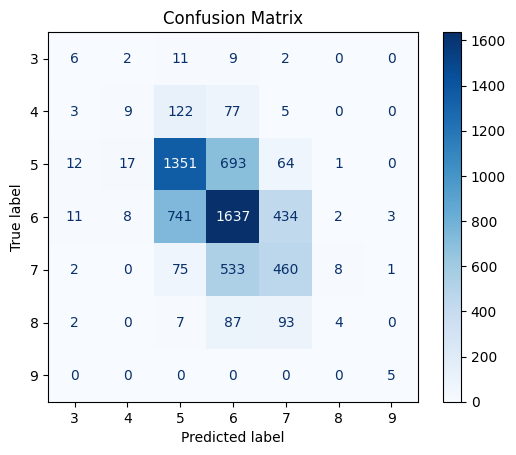

Error Probability: 0.4655995074649838


In [6]:
# Estimate class-specific parameters and classify
class_means = {}
class_covariances = {}
class_priors = {}
quality_scores = labels.unique()

for quality in quality_scores:
    class_data = features[labels == quality]
    class_means[quality] = class_data.mean()
    class_covariances[quality] = class_data.cov() + 0.01 * np.eye(class_data.shape[1])  # Regularization
    class_priors[quality] = len(class_data) / len(features)

def classify(sample):
    max_posterior = -np.inf
    chosen_class = None
    for quality in quality_scores:
        mean = class_means[quality]
        cov = class_covariances[quality]
        prior = class_priors[quality]
        likelihood = multivariate_normal(mean, cov).pdf(sample)
        posterior = likelihood * prior
        if posterior > max_posterior:
            max_posterior = posterior
            chosen_class = quality
    return chosen_class

predicted_labels = np.array([classify(row) for index, row in features.iterrows()])
error_probability = 1 - accuracy_score(labels, predicted_labels)
conf_matrix = confusion_matrix(labels, predicted_labels, labels=sorted(quality_scores))

# Visualizing the confusion matrix
plt.figure()
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=sorted(quality_scores))
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("Error Probability:", error_probability)

(2947, 561)


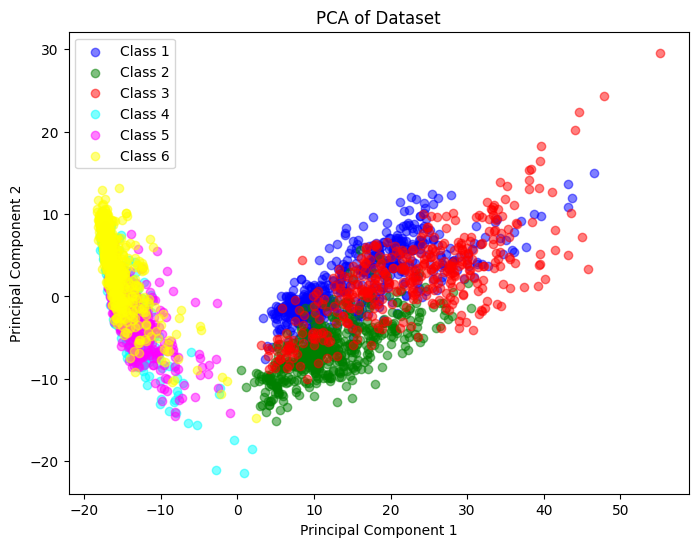

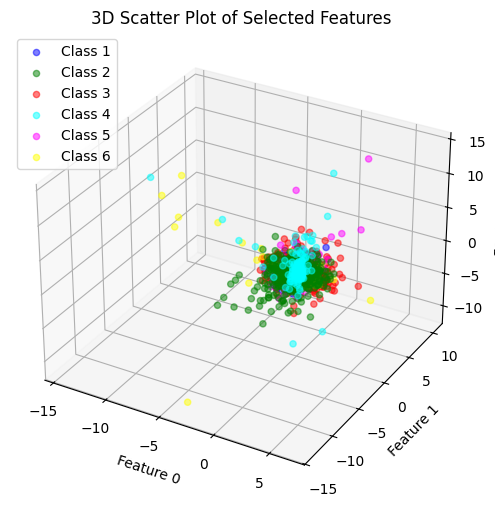

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from joblib import Parallel, delayed

# Load datasets
X_test = np.loadtxt("data/X_test.txt")
y_test = np.loadtxt("data/y_test.txt")

print(np.shape(X_test))

# Assuming the dataset is balanced, calculate the class priors
classes, class_counts = np.unique(y_test, return_counts=True)
class_priors = {cls: count / len(y_test) for cls, count in zip(classes, class_counts)}

# Standardize the features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Estimate class-specific parameters
class_means = {}
class_covariances = {}

for cls in classes:
    class_data = X_test_scaled[y_test == cls]
    class_means[cls] = np.mean(class_data, axis=0)
    covariance_matrix = np.cov(class_data, rowvar=False)
    # Regularize covariance matrix
    lambda_reg = 0.01
    class_covariances[cls] = covariance_matrix + lambda_reg * np.eye(covariance_matrix.shape[0])

# Classification function using vectorized operations
def classify(sample):
    max_posterior = -np.inf
    chosen_class = None
    for cls in classes:
        mean = class_means[cls]
        cov = class_covariances[cls]
        prior = class_priors[cls]
        likelihood = multivariate_normal(mean, cov).pdf(sample)
        posterior = likelihood * prior
        if posterior > max_posterior:
            max_posterior = posterior
            chosen_class = cls
    return chosen_class

# Apply the classifier to all samples using parallel processing

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
color_map = {cls: colors[i % len(colors)] for i, cls in enumerate(classes)}

# 3D PCA Visualization with separate colors for each class
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot each class with a separate color
for cls in classes:
    indices = np.where(y_test == cls)
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], 
               color=color_map[cls], label=f'Class {int(cls)}', alpha=0.5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of Dataset')
ax.legend()
plt.show()

# 3D Scatter Plot of three selected features
selected_features = [0, 1, 2]  # Indices of selected features (can be changed)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each class with a separate color
for cls in classes:
    indices = np.where(y_test == cls)
    ax.scatter(X_test_scaled[indices, selected_features[0]], 
               X_test_scaled[indices, selected_features[1]], 
               X_test_scaled[indices, selected_features[2]], 
               color=color_map[cls], label=f'Class {int(cls)}', alpha=0.5)

ax.set_xlabel(f'Feature {selected_features[0]}')
ax.set_ylabel(f'Feature {selected_features[1]}')
ax.set_zlabel(f'Feature {selected_features[2]}')
ax.set_title('3D Scatter Plot of Selected Features')
ax.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

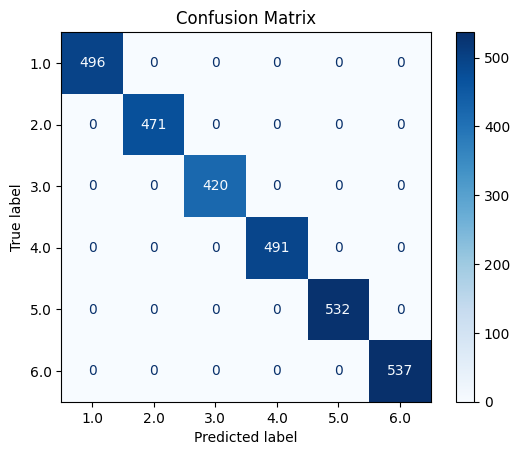

Error Probability: 0.0


In [8]:
predicted_labels = Parallel(n_jobs=-1)(delayed(classify)(sample) for sample in X_test_scaled)

# Calculate error probability
error_probability = 1 - accuracy_score(y_test, predicted_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels, labels=classes)

# Visualizing the confusion matrix
plt.figure()
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("Error Probability:", error_probability)
